In [2]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor


c:\projects\alura_postech\fiap_techchallenge04\.venv_win_autogluon\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# df = pd.read_csv("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/train.csv")
# df.head()

data = pd.read_csv("../data/petr_brent.csv")[["DATE", "VALUE (US$)"]]
data.head()


,DATE,VALUE (US$)
0,2001-01-01,NaN
1,2001-01-02,23.43
2,2001-01-03,23.44
3,2001-01-04,24.57
4,2001-01-05,24.77


In [4]:
data.index = pd.to_datetime(data["DATE"])
start = data.index[0].date()
end = data.index[len(data) - 1].date()
new_dates = pd.date_range(start=start, end=end, freq="D")
data = data.reindex(new_dates)
data = data.rename_axis("DATE")
data["VALUE (US$)"] = data["VALUE (US$)"].interpolate().bfill()
data.drop(columns=["DATE"], inplace=True)
data["item_id"] = "PETR_BRENT"
data.reset_index(inplace=True)
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8562 entries, 0 to 8561
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATE         8562 non-null   datetime64[ns]
 1   VALUE (US$)  8562 non-null   float64       
 2   item_id      8562 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 200.8+ KB


# Modelo Univariado

In [11]:
df = TimeSeriesDataFrame.from_data_frame(
    data, id_column="item_id", timestamp_column="DATE"
)
df.head()


VALUE (US$)
item_id    timestamp              
PETR_BRENT 2001-01-01        23.43
           2001-01-02        23.43
           2001-01-03        23.44
           2001-01-04        24.57
           2001-01-05        24.77

In [12]:
fh = 550
df_train, df_test = df.train_test_split(fh)


In [101]:
df_train.shape


(8012, 1)

In [102]:
df_test.shape


(8562, 1)

In [123]:
predictor = TimeSeriesPredictor(
    prediction_length=fh,
    path="autogluon-petr",
    target="VALUE (US$)",
    eval_metric="WQL",
    quantile_levels=[0.1, 0.5, 0.75, 0.9],
)


In [124]:
predictor.fit(
    df_train,
    presets="chronos_large_ensemble",
    time_limit=600,
    num_val_windows=5,
    random_seed=123,
)


Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'autogluon-petr'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22635
CPU Count:          16
GPU Count:          0
Memory Avail:       14.55 GB / 31.74 GB (45.8%)
Disk Space Avail:   217.57 GB / 930.09 GB (23.4%)
Setting presets to: chronos_large_ensemble

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'batch_size': 8, 'model_path': 'large'},
                     'DirectTabular': {},
                     'PatchTST': {},
                     'RecursiveTabular': {},
                     'SeasonalNaive': {},
                     'TemporalFusionTransformer': {}},
 'known_covariates_names': [],
 'num_val_windows': 5,
 'prediction_length': 550,
 'quantile_levels': [0.1, 0.5, 0.75, 0.9],
 'random_seed': 123,
 'refit_every_n

In [125]:
predictions = predictor.predict(df_train)
predictions.head()


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean        0.1        0.5       0.75        0.9
item_id    timestamp                                                        
PETR_BRENT 2022-12-09  82.879565  75.320338  82.879565  86.712752  90.438788
           2022-12-10  81.905416  67.277178  81.905416  89.276304  96.533659
           2022-12-11  80.621385  74.639638  80.621385  83.678537  86.603131
           2022-12-12  78.804955  66.704999  78.804955  84.868153  90.904904
           2022-12-13  87.072903  75.527767  87.072903  92.885075  98.618038

In [126]:
predictions.tail()


mean        0.1        0.5        0.75         0.9
item_id    timestamp                                                          
PETR_BRENT 2024-06-06  79.031363  40.465500  79.031363   98.731581  117.597225
           2024-06-07  82.666487  44.788557  82.666487  102.017500  120.544414
           2024-06-08  82.172674  42.920115  82.172674  102.229253  121.425219
           2024-06-09  81.633428  43.118326  81.633428  101.351460  120.148531
           2024-06-10  81.148716  42.537357  81.148716  100.871067  119.760072

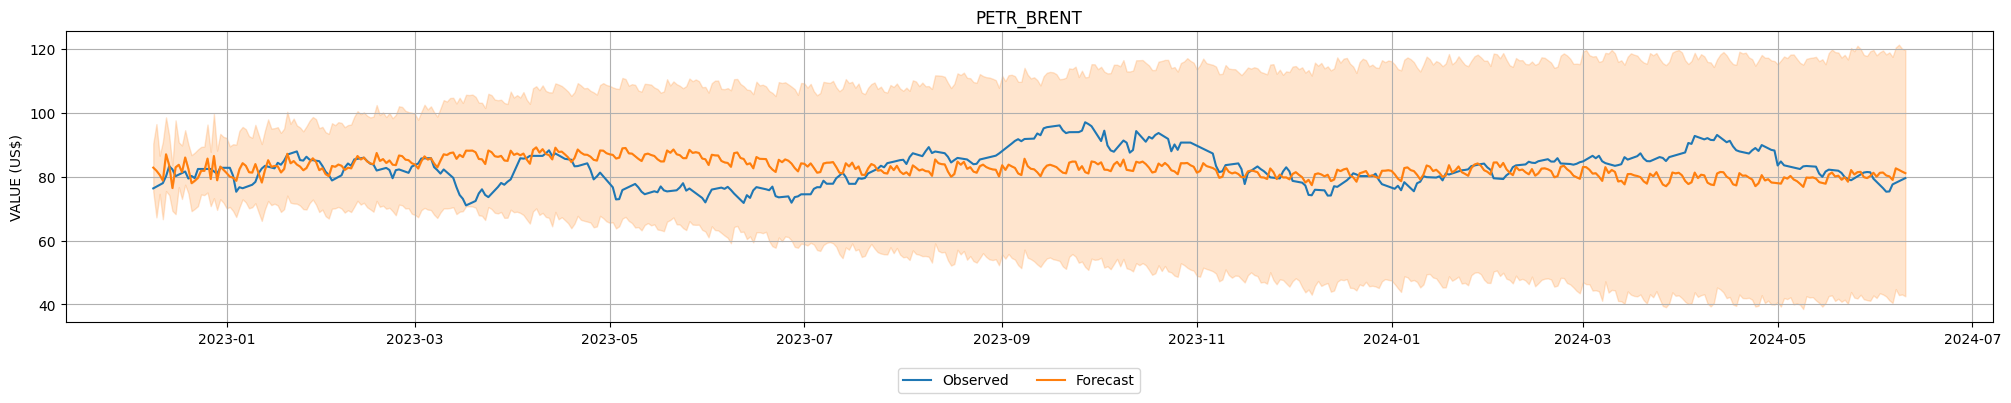

In [127]:
import matplotlib.pyplot as plt

predictor.plot(
    df_test[df_train.shape[0] :],
    predictions,
    quantile_levels=[0.1, 0.9],
)


In [128]:
# The test score is computed using the last
# prediction_length=48 timesteps of each time series in test_data
predictor.leaderboard(df_test)


Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.069717,-0.168102,3.117667,2.410249,2.437649,6
1,PatchTST,-0.070342,-0.168985,0.180438,0.077797,152.445505,5
2,SeasonalNaive,-0.072363,-0.174013,2.937230,2.332452,10.465849,1
3,TemporalFusionTransformer,-0.106775,-0.340207,0.189957,0.095807,153.771014,4
4,RecursiveTabular,-0.119004,-0.213089,7.102870,6.919601,42.306494,2
5,DirectTabular,-0.208628,-0.314656,0.333141,0.346336,73.156058,3


In [129]:
predictor.fit_summary()


****************** Summary of fit() ******************
Estimated performance of each model:
                       model  score_val  pred_time_val  fit_time_marginal  \
0           WeightedEnsemble  -0.168102       2.410249           2.437649   
1                   PatchTST  -0.168985       0.077797         152.445505   
2              SeasonalNaive  -0.174013       2.332452          10.465849   
3           RecursiveTabular  -0.213089       6.919601          42.306494   
4              DirectTabular  -0.314656       0.346336          73.156058   
5  TemporalFusionTransformer  -0.340207       0.095807         153.771014   

   fit_order  
0          6  
1          5  
2          1  
3          2  
4          3  
5          4  
Number of models trained: 6
Types of models trained:
{'TimeSeriesGreedyEnsemble', 'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


{'model_types': {'SeasonalNaive': 'MultiWindowBacktestingModel',
  'RecursiveTabular': 'MultiWindowBacktestingModel',
  'DirectTabular': 'MultiWindowBacktestingModel',
  'TemporalFusionTransformer': 'MultiWindowBacktestingModel',
  'PatchTST': 'MultiWindowBacktestingModel',
  'WeightedEnsemble': 'TimeSeriesGreedyEnsemble'},
 'model_performance': {'SeasonalNaive': -0.17401316879038461,
  'RecursiveTabular': -0.21308877803921863,
  'DirectTabular': -0.3146561608817997,
  'TemporalFusionTransformer': -0.3402070936403767,
  'PatchTST': -0.16898489571971104,
  'WeightedEnsemble': -0.1681024481945283},
 'model_best': 'WeightedEnsemble',
 'model_paths': {'SeasonalNaive': ['SeasonalNaive'],
  'RecursiveTabular': ['RecursiveTabular'],
  'DirectTabular': ['DirectTabular'],
  'TemporalFusionTransformer': ['TemporalFusionTransformer'],
  'PatchTST': ['PatchTST'],
  'WeightedEnsemble': ['WeightedEnsemble']},
 'model_fit_times': {'SeasonalNaive': 10.465848684310913,
  'RecursiveTabular': 42.30649399

In [130]:
predictor_1 = TimeSeriesPredictor.load("autogluon-petr")


Loading predictor from path autogluon-petr


In [131]:
predictions = predictor_1.predict(df_train)


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


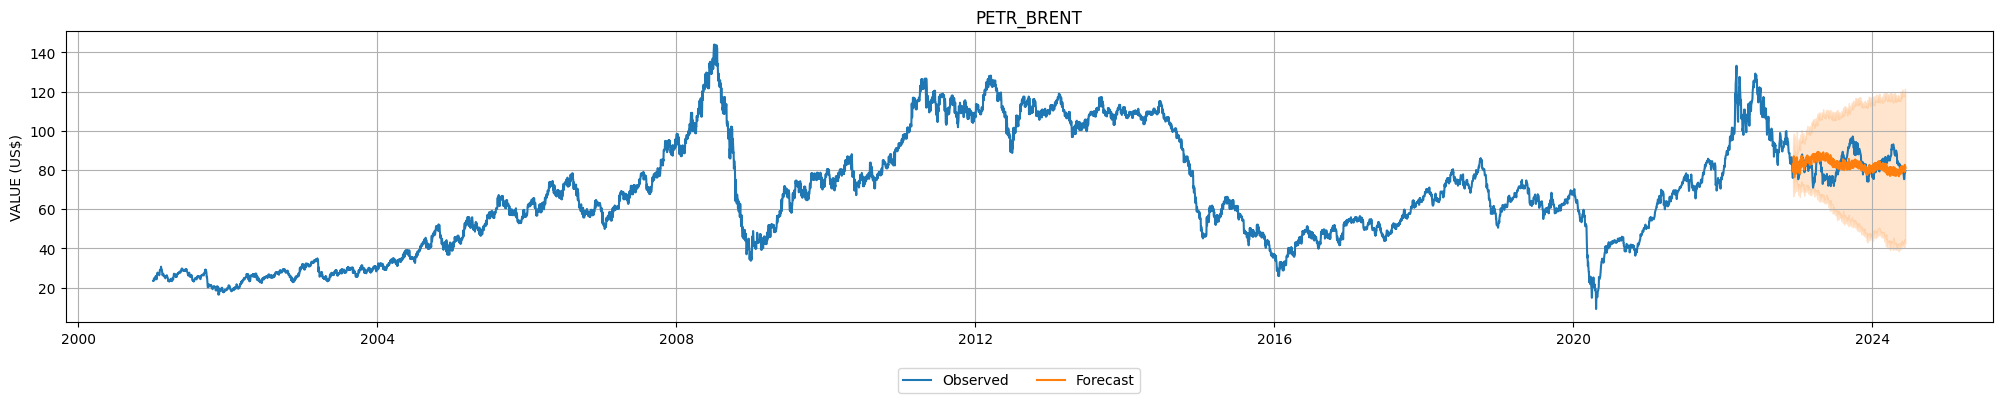

In [132]:
predictor_1.plot(df_test, predictions=predictions, quantile_levels=[0.1, 0.5, 0.9])


# Modelo Multivariado

In [5]:
# Cria as features para o modelo multivariado (covariates)
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.day_of_week
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.day_of_year
    return df


df_mult = create_features(data.set_index("DATE"))
df_mult.head()


,VALUE (US$),item_id,hour,dayofweek,quarter,month,year,dayofyear
DATE,,,,,,,,
2001-01-01,23.43,PETR_BRENT,0,0,1,1,2001,1
2001-01-02,23.43,PETR_BRENT,0,1,1,1,2001,2
2001-01-03,23.44,PETR_BRENT,0,2,1,1,2001,3
2001-01-04,24.57,PETR_BRENT,0,3,1,1,2001,4
2001-01-05,24.77,PETR_BRENT,0,4,1,1,2001,5


In [7]:
df_mult = TimeSeriesDataFrame.from_data_frame(
    df_mult.reset_index(),
    id_column="item_id",
    timestamp_column="DATE",
)


In [8]:
df_mult.head()


VALUE (US$)  hour  dayofweek  quarter  month  year  \
item_id    timestamp                                                        
PETR_BRENT 2001-01-01        23.43     0          0        1      1  2001   
           2001-01-02        23.43     0          1        1      1  2001   
           2001-01-03        23.44     0          2        1      1  2001   
           2001-01-04        24.57     0          3        1      1  2001   
           2001-01-05        24.77     0          4        1      1  2001   

                       dayofyear  
item_id    timestamp              
PETR_BRENT 2001-01-01          1  
           2001-01-02          2  
           2001-01-03          3  
           2001-01-04          4  
           2001-01-05          5

In [15]:
df_mult_train, df_mult_test = df_mult.train_test_split(prediction_length=fh)


In [16]:
predictor = TimeSeriesPredictor(
    prediction_length=fh,
    path="autogluon-petr-mult",
    target="VALUE (US$)",
    eval_metric="WQL",
    quantile_levels=[0.1, 0.5, 0.75, 0.9],
    known_covariates_names=[
        "hour",
        "dayofweek",
        "quarter",
        "month",
        "year",
        "dayofyear",
    ],
)


In [18]:
predictor.fit(
    df_mult_train,
    presets="chronos_large_ensemble",
    time_limit=600,
    num_val_windows=5,
    random_seed=123,
)


Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'autogluon-petr-mult'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22635
CPU Count:          16
GPU Count:          0
Memory Avail:       16.75 GB / 31.74 GB (52.8%)
Disk Space Avail:   217.49 GB / 930.09 GB (23.4%)
Setting presets to: chronos_large_ensemble

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'D',
 'hyperparameters': {'Chronos': {'batch_size': 8, 'model_path': 'large'},
                     'DirectTabular': {},
                     'PatchTST': {},
                     'RecursiveTabular': {},
                     'SeasonalNaive': {},
                     'TemporalFusionTransformer': {}},
 'known_covariates_names': ['hour',
                            'dayofweek',
                            'quarter',
                         

In [21]:
predictions = predictor.predict(df_mult_train)
predictions.head()


AssertionError: known_covariates must be provided at prediction time